# Testing penultimate layer reconstruction
This notebook tests the reconstruction quality of data decoded from the penultimate layer of a classification model.
The various setups are as follows:
- Standard classifier, with decoder trained on penultimate layer (classifier weights frozen, only trained on cross-entropy loss)
- Joint Training, with a joint loss for the classifier of reconstruction and cross-entropy loss (and of course only reconstruction loss for decoder)
- Separate training of encoder and classification layer, where the encoder is trained only to minimise reconstruciton loss (i.e. a classifier layer is trained on the latent space of an autoencoder)
- Supervised VAE, with a joint loss function and variational inference/latent regularisation



Set this to True if in Drive

In [18]:
inDrive = True

In [19]:
if inDrive:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir('/content/drive/My Drive/Hybrid-CLUE/MyImplementation/testing_notebooks')
    import sys

    # Add the parent directory to the system path
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    sys.path.insert(0, parent_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
training = True

## Setup


Import libraries

In [29]:
import importlib
import models.regene_models as regene_models
importlib.reload(regene_models)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

Set the device

In [22]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


Load the Datasets

In [30]:
import torch
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

# Define the split ratio (e.g., 80% train, 20% validation)
train_ratio = 0.8
val_ratio = 1 - train_ratio

# Calculate the sizes of the splits
train_size = int(train_ratio * len(trainset))
val_size = len(trainset) - train_size

# Perform the split
train_subset, val_subset = random_split(trainset, [train_size, val_size])

# Create data loaders for the splits
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Set the latent dimension

In [34]:
latent_dim = 256
epochs = 50

Create a models directory if it doesn't exist

In [35]:
# Create models directory in parent directory if it doesn't exist
os.makedirs(os.path.join('..', 'model_saves', 'new_regene_models'), exist_ok=True)
model_saves_path = os.path.join('..', 'model_saves', 'new_regene_models')

## Classifier-dominated training

### Classifier Training

First we define the classifier

In [36]:
classifier = regene_models.Classifier(latent_dim=latent_dim, num_classes=10, device=device)

Then we train

In [37]:
# Train classifier and save
if training:
    classifier.train_classifier(trainloader, val_loader=valloader, num_epochs=epochs, lr=0.001, patience=10, model_saves_dir=model_saves_path)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Loss: 0.1151
Epoch [1/50], Val Loss: 0.0632
Saved best model to: ../model_saves/new_regene_models/classifier_dominated_classifier_256.pt
Epoch [2/50], Train Loss: 0.0443
Epoch [2/50], Val Loss: 0.0463
Saved best model to: ../model_saves/new_regene_models/classifier_dominated_classifier_256.pt
Epoch [3/50], Train Loss: 0.0341
Epoch [3/50], Val Loss: 0.0549
Epoch [4/50], Train Loss: 0.0265
Epoch [4/50], Val Loss: 0.0487
Epoch [5/50], Train Loss: 0.0237
Epoch [5/50], Val Loss: 0.0461
Saved best model to: ../model_saves/new_regene_models/classifier_dominated_classifier_256.pt
Epoch [6/50], Train Loss: 0.0173
Epoch [6/50], Val Loss: 0.0319
Saved best model to: ../model_saves/new_regene_models/classifier_dominated_classifier_256.pt
Epoch [7/50], Train Loss: 0.0155
Epoch [7/50], Val Loss: 0.0472
Epoch [8/50], Train Loss: 0.0138
Epoch [8/50], Val Loss: 0.0365
Epoch [9/50], Train Loss: 0.0126
Epoch [9/50], Val Loss: 0.0401
Epoch [10/50], Train Loss: 0.0030
Epoch [10/50], Val

### Classifier Loading
Load the classifier

In [ ]:
classifier.load_state_dict(torch.load(os.path.join(model_saves_path, 'classifier.pth'), map_location=device))

/var/folders/tb/ccwl9r592hn9v_xpq9s1bzlr0000gn/T/ipykernel_13002/1365348556.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(os.path

<All keys matched successfully>

### Classifier Testing


First let's test the classifier on a few images

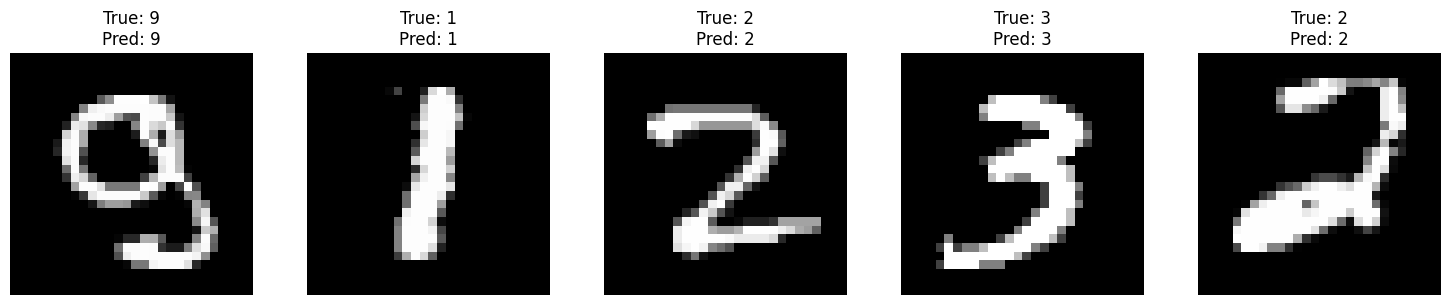

In [38]:
# Get random indices for test images
random_indices = torch.randint(0, len(testset), (5,))
images = torch.stack([testset[i][0] for i in random_indices])
labels = torch.tensor([testset[i][1] for i in random_indices])

# Get predictions
classifier.eval()  # Set to evaluation mode
with torch.no_grad():
    images = images.to(device)
    _, predictions = classifier(images)
    predicted_classes = torch.argmax(predictions, dim=1)

# Plot images with true and predicted labels
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i].cpu().squeeze().numpy(), cmap='gray')
    plt.title(f'True: {labels[i].item()}\nPred: {predicted_classes[i].cpu().item()}')
    plt.axis('off')

plt.tight_layout()
plt.show()


We'll also visualise the latent space. This is done by taking the latent representations of 50 training images and plotting them in 2D using t-SNE.

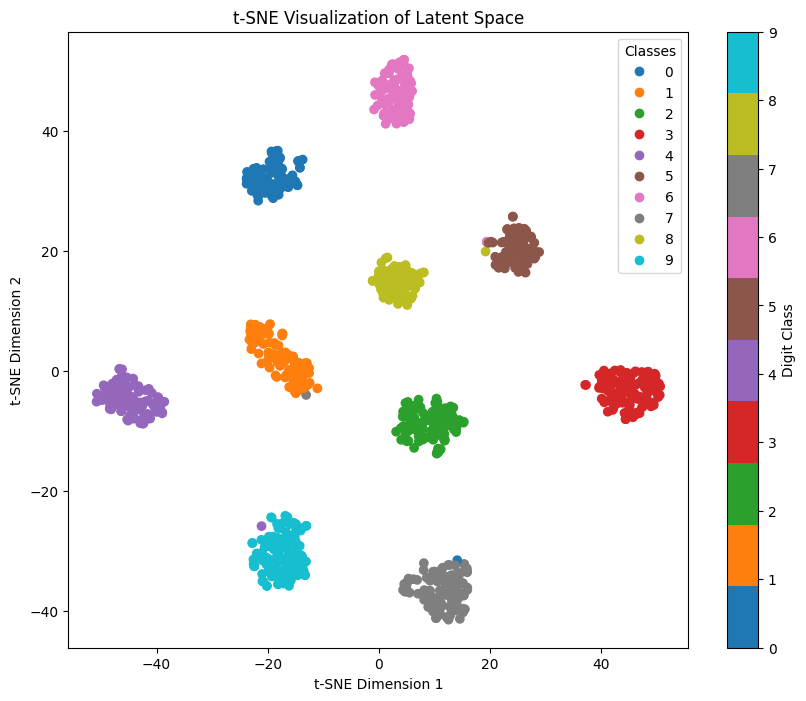

In [39]:
# Get latent representations for 50 random training images
random_indices = torch.randint(0, len(testset), (1000,))
images = torch.stack([testset[i][0] for i in random_indices])
labels = torch.tensor([testset[i][1] for i in random_indices])

# Get latent representations
classifier.eval()
with torch.no_grad():
    images = images.to(device)
    latent_reps, _ = classifier(images)
    latent_reps = latent_reps.cpu().numpy()

# Perform t-SNE dimensionality reduction
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_reps)

# Plot the 2D latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10')
plt.colorbar(scatter, label='Digit Class')
plt.title('t-SNE Visualization of Latent Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()


### Decoder Training

We define the decoder, and then train it using the classifier's latent space.

In [40]:
decoder = regene_models.Decoder(latent_dim=latent_dim, device=device)

In [43]:
if training:
    decoder.train_decoder(trainloader, classifier, num_epochs=epochs, lr=0.001, model_saves_dir=model_saves_path, patience=10, val_loader=valloader,)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Decoder Epoch [1/50], Train Loss: 0.0164
Decoder Epoch [1/50], Val Loss: 0.0158
Saved best model to: ../model_saves/new_regene_models/classifier_dominated_decoder_256.pt
Decoder Epoch [2/50], Train Loss: 0.0154
Decoder Epoch [2/50], Val Loss: 0.0151
Saved best model to: ../model_saves/new_regene_models/classifier_dominated_decoder_256.pt
Decoder Epoch [3/50], Train Loss: 0.0147
Decoder Epoch [3/50], Val Loss: 0.0147
Saved best model to: ../model_saves/new_regene_models/classifier_dominated_decoder_256.pt
Decoder Epoch [4/50], Train Loss: 0.0143
Decoder Epoch [4/50], Val Loss: 0.0144
Saved best model to: ../model_saves/new_regene_models/classifier_dominated_decoder_256.pt
Decoder Epoch [5/50], Train Loss: 0.0138
Decoder Epoch [5/50], Val Loss: 0.0143
Saved best model to: ../model_saves/new_regene_models/classifier_dominated_decoder_256.pt
Decoder Epoch [6/50], Train Loss: 0.0135
Decoder Epoch [6/50], Val Loss: 0.0143
Decoder Epoch [7/50], Train Loss: 0.0132
Decoder Epoch [7/50], Val Los

### Decoder Loading
Load the decoder

In [ ]:
decoder.load_state_dict(torch.load(os.path.join(model_saves_path, 'decoder.pth'), map_location=device))

/var/folders/tb/ccwl9r592hn9v_xpq9s1bzlr0000gn/T/ipykernel_13002/1833794902.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder.load_state_dict(torch.load(os.path.jo

<All keys matched successfully>

### Decoder Testing


First less visualise some reconstructions

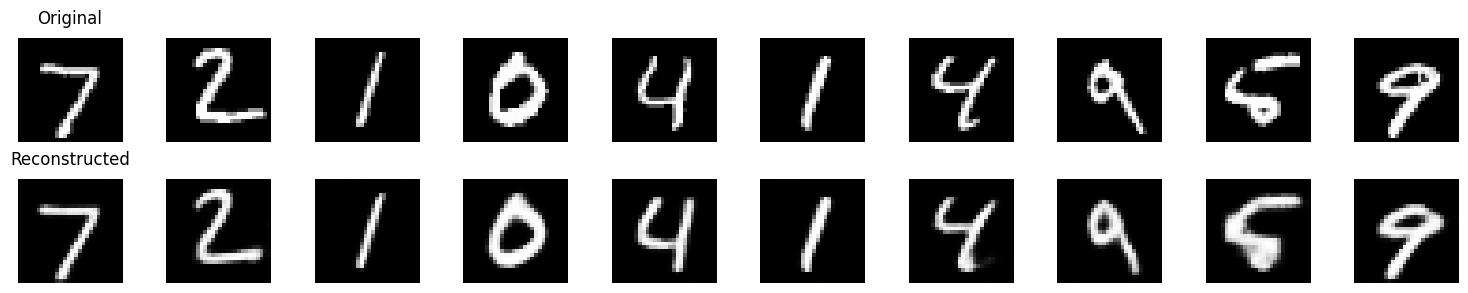

In [44]:
# Get 10 random images from training set
dataiter = iter(testloader)
images, _ = next(dataiter)
images = images[:10].to(device)

# Get reconstructions
classifier.eval()
decoder.eval()
with torch.no_grad():
    z, _ = classifier(images)
    reconstructed = decoder(z)

# Plot original vs reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    # Original images
    axes[0,i].imshow(images[i].cpu().squeeze(), cmap='gray')
    axes[0,i].axis('off')
    if i == 0:
        axes[0,i].set_title('Original', pad=10)

    # Reconstructed images
    axes[1,i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
    axes[1,i].axis('off')
    if i == 0:
        axes[1,i].set_title('Reconstructed', pad=10)

plt.tight_layout()
plt.show()


## Joint training


### Training
Train the models

Let's try training the models with a joint objective

In [45]:
from importlib import reload
import models.regene_models as regene_models
importlib.reload(regene_models)
from models.regene_models import Classifier

Alpha determines how much weight is given to the reconstruction loss.

In [51]:
joint_decoder = regene_models.Decoder(latent_dim=latent_dim, device=device)
joint_classifier = regene_models.Classifier(latent_dim=latent_dim, num_classes=10, device=device)

if training:
    regene_models.train_joint(joint_classifier, joint_decoder, trainloader, num_epochs=epochs, lr=0.001, lambda_recon=0.8, val_loader=valloader, patience=10, model_saves_dir=model_saves_path)

Epoch [1/50], Train Total Loss: 0.0517, Train Classification Loss: 0.1152, Train Reconstruction Loss: 0.0358
Epoch [1/50], Val Total Loss: 0.0236, Val Classification Loss: 0.0436, Val Reconstruction Loss: 0.0185
Saved best models to: ../model_saves/new_regene_models/joint_classifier_256.pt and ../model_saves/new_regene_models/joint_decoder_256.pt
Epoch [2/50], Train Total Loss: 0.0205, Train Classification Loss: 0.0418, Train Reconstruction Loss: 0.0152
Epoch [2/50], Val Total Loss: 0.0187, Val Classification Loss: 0.0418, Val Reconstruction Loss: 0.0130
Saved best models to: ../model_saves/new_regene_models/joint_classifier_256.pt and ../model_saves/new_regene_models/joint_decoder_256.pt
Epoch [3/50], Train Total Loss: 0.0167, Train Classification Loss: 0.0344, Train Reconstruction Loss: 0.0123
Epoch [3/50], Val Total Loss: 0.0153, Val Classification Loss: 0.0301, Val Reconstruction Loss: 0.0116
Saved best models to: ../model_saves/new_regene_models/joint_classifier_256.pt and ../mode

### Loading
Load the models

In [ ]:
joint_classifier.load_state_dict(torch.load(os.path.join(model_saves_path, 'joint_classifier.pth'), map_location=device))
joint_decoder.load_state_dict(torch.load(os.path.join(model_saves_path, 'joint_decoder.pth'), map_location=device))

/var/folders/tb/ccwl9r592hn9v_xpq9s1bzlr0000gn/T/ipykernel_13002/3085312799.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  joint_classifier.load_state_dict(torch.load(o

<All keys matched successfully>

### Testing
Test the models


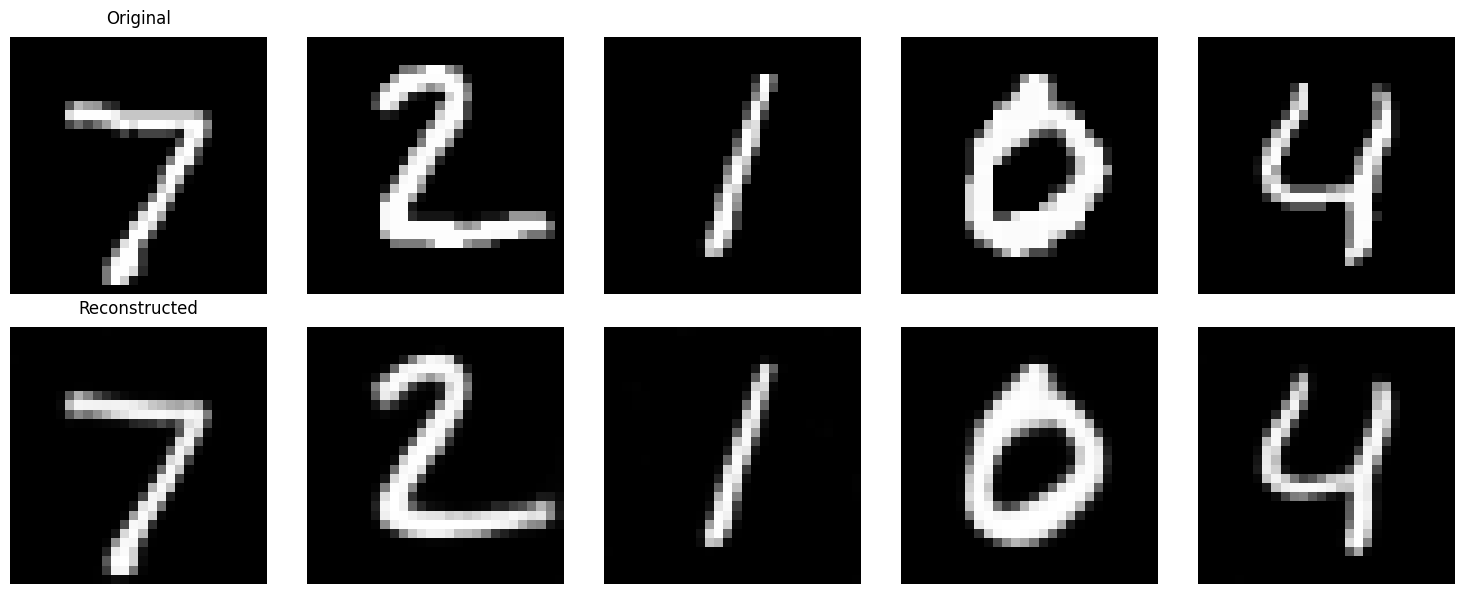

In [47]:
# Get some test images
dataiter = iter(testloader)
images, labels = next(dataiter)
images = images.to(device)

# Get reconstructions
with torch.no_grad():
    z, _ = joint_classifier(images)
    reconstructed = joint_decoder(z)

# Plot original vs reconstructed images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Original images
    axes[0,i].imshow(images[i].cpu().squeeze(), cmap='gray')
    axes[0,i].axis('off')
    if i == 0:
        axes[0,i].set_title('Original', pad=10)

    # Reconstructed images
    axes[1,i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
    axes[1,i].axis('off')
    if i == 0:
        axes[1,i].set_title('Reconstructed', pad=10)

plt.tight_layout()
plt.show()


## Training encoder and classifier separately


In this final section, we will train the encoder and classifier separately. The encoder is trained to minimise the reconstruction loss, and the classifier is trained to minimise the cross-entropy loss on the enocders latent space.

Define models

In [52]:
from models.regene_models import train_autoencoder, train_classifier_only

separate_classifier = regene_models.Classifier(latent_dim=latent_dim, num_classes=10, device=device)
separate_decoder = regene_models.Decoder(latent_dim=latent_dim, device=device)

### Training
Train the autoencoder

In [53]:
if training:
    # Train autoencoder
    train_autoencoder(classifier=separate_classifier, decoder=separate_decoder, train_loader=trainloader, num_epochs=epochs, lr=0.001, val_loader=valloader, patience = 10, model_saves_dir=model_saves_path)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Reconstruction Loss: 0.0280
Epoch [1/50], Val Reconstruction Loss: 0.0078
Saved best models to: ../model_saves/new_regene_models/autoencoder_dominated_classifier_encoder_only_256.pt and ../model_saves/new_regene_models/autoencoder_dominated_decoder_256.pt
Epoch [2/50], Train Reconstruction Loss: 0.0060
Epoch [2/50], Val Reconstruction Loss: 0.0052
Saved best models to: ../model_saves/new_regene_models/autoencoder_dominated_classifier_encoder_only_256.pt and ../model_saves/new_regene_models/autoencoder_dominated_decoder_256.pt
Epoch [3/50], Train Reconstruction Loss: 0.0045
Epoch [3/50], Val Reconstruction Loss: 0.0041
Saved best models to: ../model_saves/new_regene_models/autoencoder_dominated_classifier_encoder_only_256.pt and ../model_saves/new_regene_models/autoencoder_dominated_decoder_256.pt
Epoch [4/50], Train Reconstruction Loss: 0.0038
Epoch [4/50], Val Reconstruction Loss: 0.0037
Saved best models to: ../model_saves/new_regene_models/autoencoder_dominated_c

Train the classifier layer

In [54]:
if training:
    # Train autoencoder
    train_classifier_only(separate_classifier, trainloader, num_epochs=epochs, lr=0.001, val_loader=valloader, patience=10, model_saves_dir=model_saves_path)

Epoch [1/50], Train Loss: 0.5854
Epoch [1/50], Val Loss: 0.3041
Saved best model to: ../model_saves/new_regene_models/autoencoder_dominated_classifier_full_256.pt
Epoch [2/50], Train Loss: 0.2714
Epoch [2/50], Val Loss: 0.2636
Saved best model to: ../model_saves/new_regene_models/autoencoder_dominated_classifier_full_256.pt
Epoch [3/50], Train Loss: 0.2406
Epoch [3/50], Val Loss: 0.2468
Saved best model to: ../model_saves/new_regene_models/autoencoder_dominated_classifier_full_256.pt
Epoch [4/50], Train Loss: 0.2236
Epoch [4/50], Val Loss: 0.2204
Saved best model to: ../model_saves/new_regene_models/autoencoder_dominated_classifier_full_256.pt
Epoch [5/50], Train Loss: 0.2158
Epoch [5/50], Val Loss: 0.2053
Saved best model to: ../model_saves/new_regene_models/autoencoder_dominated_classifier_full_256.pt
Epoch [6/50], Train Loss: 0.2079
Epoch [6/50], Val Loss: 0.2213
Epoch [7/50], Train Loss: 0.2020
Epoch [7/50], Val Loss: 0.2083
Epoch [8/50], Train Loss: 0.2004
Epoch [8/50], Val Loss: 

### Loading
Load the models

In [ ]:
separate_classifier.load_state_dict(torch.load(os.path.join(model_saves_path, 'separate_classifier.pth'), map_location=device))
separate_decoder.load_state_dict(torch.load(os.path.join(model_saves_path, 'separate_decoder.pth'), map_location=device))

/var/folders/tb/ccwl9r592hn9v_xpq9s1bzlr0000gn/T/ipykernel_13002/2821388973.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  separate_classifier.load_state_dict(torch.loa

<All keys matched successfully>

## Supervised Variational Autoencoder

### Setup

Define model

In [55]:
from models.SVAE import SVAE

svae = SVAE(latent_dim=latent_dim, num_classes=10, device=device)

Train model

In [ ]:
if training:
    svae.train_model(trainloader, num_epochs=5, lr=0.001, beta=0.01, alpha=10.0)
    # Save the trained SVAE model
    torch.save(svae.state_dict(), os.path.join(model_saves_path, 'svae_model.pth'))


Load model

In [57]:
svae.load_state_dict(torch.load(os.path.join('../model_saves', 'svae_model.pth'), map_location=device))

<ipython-input-57-37a0b1cc4bd3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  svae.load_state_dict(torch.load(os.path.join('../model_saves', 'svae_model.pth'), map_locati

<All keys matched successfully>

### Testing
Test the model

First let's simply qualitatively test the model's ability to recosntruct and classify a few images.

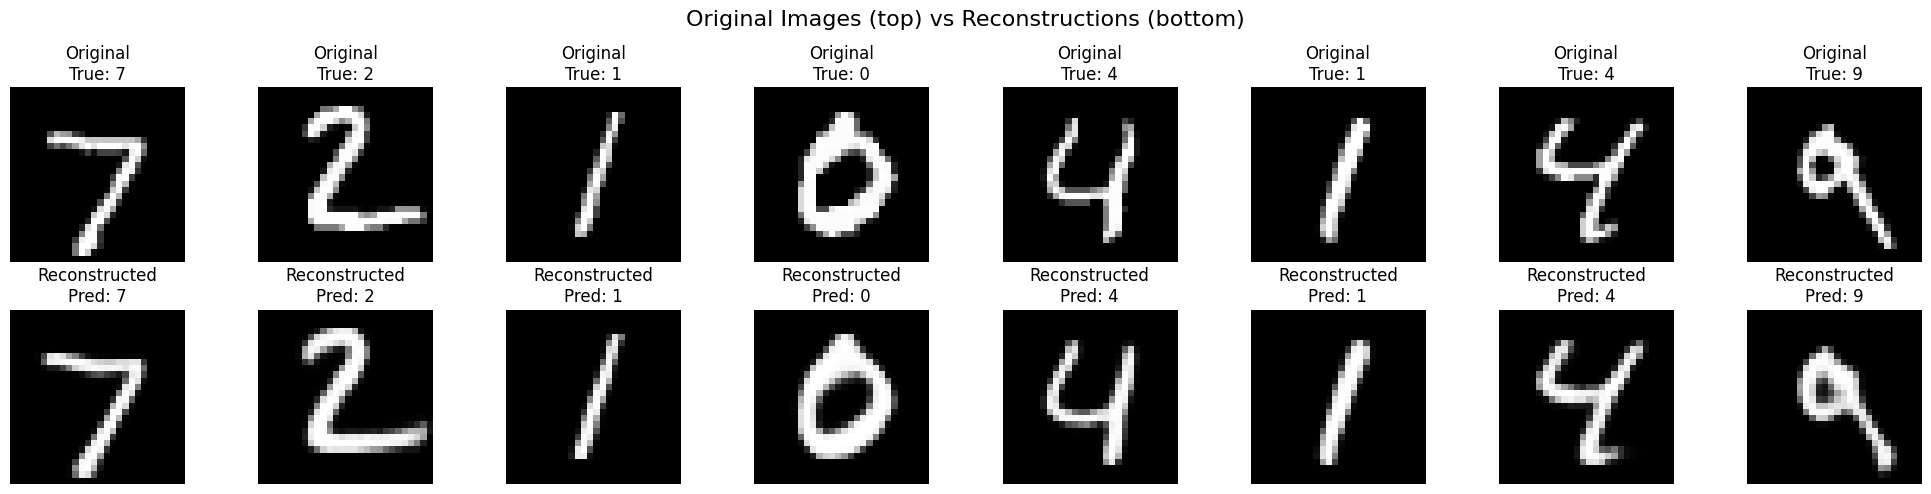

In [58]:
# Test SVAE reconstruction and classification
test_images, test_labels = next(iter(testloader))
test_images = test_images.to(device)
test_labels = test_labels.to(device)

# Get reconstructions and predictions
with torch.no_grad():
    # Change this line - the SVAE forward method returns (x_recon, y_pred, mu, log_var)
    x_recon, y_pred, mu, log_var = svae(test_images)
    # Apply softmax before argmax
    pred_probs = torch.softmax(y_pred, dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)

# Convert tensors to numpy for plotting
test_images = test_images.cpu().numpy()
recon_batch = x_recon.cpu().numpy()
test_labels = test_labels.cpu().numpy()
pred_labels = pred_labels.cpu().numpy()

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 8, figsize=(20, 5))
fig.suptitle('Original Images (top) vs Reconstructions (bottom)', fontsize=16)

for i in range(8):
    # Original images
    axes[0, i].imshow(test_images[i].squeeze(), cmap='gray')
    axes[0, i].set_title(f'Original\nTrue: {test_labels[i]}')
    axes[0, i].axis('off')

    # Reconstructed images
    axes[1, i].imshow(recon_batch[i].squeeze(), cmap='gray')
    axes[1, i].set_title(f'Reconstructed\nPred: {pred_labels[i]}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


Next, let's get a proper MSE reconstruction error and classification accuracy.

In [59]:
# Calculate MSE loss and classification accuracy
mse_loss = nn.MSELoss()
total_mse = 0
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        # Get model outputs
        recon, pred, mu, log_var = svae(images)

        # Calculate MSE
        total_mse += mse_loss(recon, images).item() * images.size(0)

        # Calculate accuracy
        pred_probs = torch.softmax(pred, dim=1)
        pred_labels = torch.argmax(pred_probs, dim=1)
        total_correct += (pred_labels == labels).sum().item()
        total_samples += labels.size(0)

# Calculate averages
avg_mse = total_mse / total_samples
accuracy = 100 * total_correct / total_samples

print(f"Test Set Results:")
print(f"Average MSE: {avg_mse:.4f}")
print(f"Classification Accuracy: {accuracy:.2f}%")


Test Set Results:
Average MSE: 0.0051
Classification Accuracy: 99.14%


Finally, we'll visualise the latent space of the SVAE.

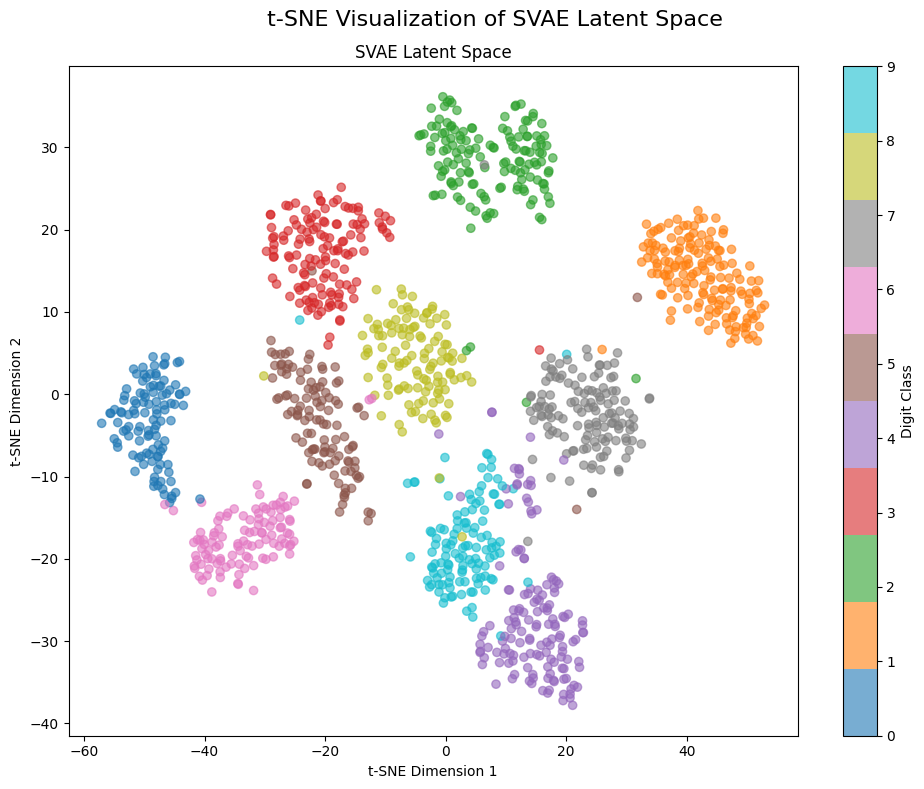

In [60]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Get more images from trainloader
all_images = []
all_labels = []
num_batches = 20  # Increased from 5 to 20 batches of data

for i, (images, labels) in enumerate(testloader):
    if i >= num_batches:
        break
    all_images.append(images)
    all_labels.append(labels)

# Concatenate all batches
test_images_tensor = torch.cat(all_images, dim=0).to(device)
test_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Get latent representations for test data
with torch.no_grad():
    mu, log_var = svae.encode(test_images_tensor)
    z = svae.reparameterize(mu, log_var)
    latent_reps = z.cpu().numpy()

# Create the figure for t-SNE visualization
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle('t-SNE Visualization of SVAE Latent Space', fontsize=16)

# Run t-SNE and plot
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_reps)
scatter = ax.scatter(latent_2d[:, 0], latent_2d[:, 1], c=test_labels, cmap='tab10', alpha=0.6)
ax.set_title('SVAE Latent Space')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')

# Add colorbar
plt.colorbar(scatter, label='Digit Class')

plt.tight_layout()
plt.show()


## Comparison

We will now compare the performance of the different models.



First we need to create wrapper classes so that the SVAE can be used in the same way as the other models. This makes our testing loops more straightforward.

In [61]:
# Create wrapper classes to make SVAE behave like classifier/decoder pairs
class SVAEClassifier(nn.Module):
    def __init__(self, svae):
        super().__init__()
        self.svae = svae

    def forward(self, x):
        # SVAE forward returns (x_recon, y_pred, mu, log_var)
        _, y_pred, mu, log_var = self.svae(x)
        z = self.svae.reparameterize(mu, log_var)
        return z, y_pred

class SVAEDecoder(nn.Module):
    def __init__(self, svae):
        super().__init__()
        self.svae = svae

    def forward(self, z):
        return self.svae.decode(z)

# Create wrapped SVAE models
svae_classifier = SVAEClassifier(svae).to(device)
svae_decoder = SVAEDecoder(svae).to(device)

In [62]:
models = [(classifier, decoder), (joint_classifier, joint_decoder), (separate_classifier, separate_decoder), (svae_classifier, svae_decoder)]


In [66]:
%pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [68]:
import torch.nn.functional as F
from torchmetrics import Accuracy
import pandas as pd
from IPython.display import display

# Function to calculate metrics
def calculate_metrics(classifier, decoder, test_loader):
    classifier.eval()
    decoder.eval()

    total = 0
    correct = 0
    mse_total = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get predictions and reconstructions
            z, outputs = classifier(images)
            reconstructed = decoder(z)

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Calculate MSE
            mse = F.mse_loss(reconstructed, images)
            mse_total += mse.item()

    accuracy = 100 * correct / total
    avg_mse = mse_total / len(test_loader)

    return accuracy, avg_mse

# Calculate metrics for each model
model_names = ['Classifier-dominated', 'Joint Training', 'Autoencoder-dominated', 'SVAE']
results = []

for (clf, dec), name in zip(models, model_names):
    accuracy, mse = calculate_metrics(clf, dec, testloader)
    results.append({
        'Model': name,
        'Accuracy (%)': f'{accuracy:.2f}',
        'MSE': f'{mse:.4f}'
    })

# Create and display DataFrame
df = pd.DataFrame(results)
display(df)


,Model,Accuracy (%),MSE
0,Classifier-dominated,99.50,0.0113
1,Joint Training,99.38,0.0033
2,Autoencoder-dominated,95.14,0.0014
3,SVAE,99.14,0.0044


And compare their latent spaces

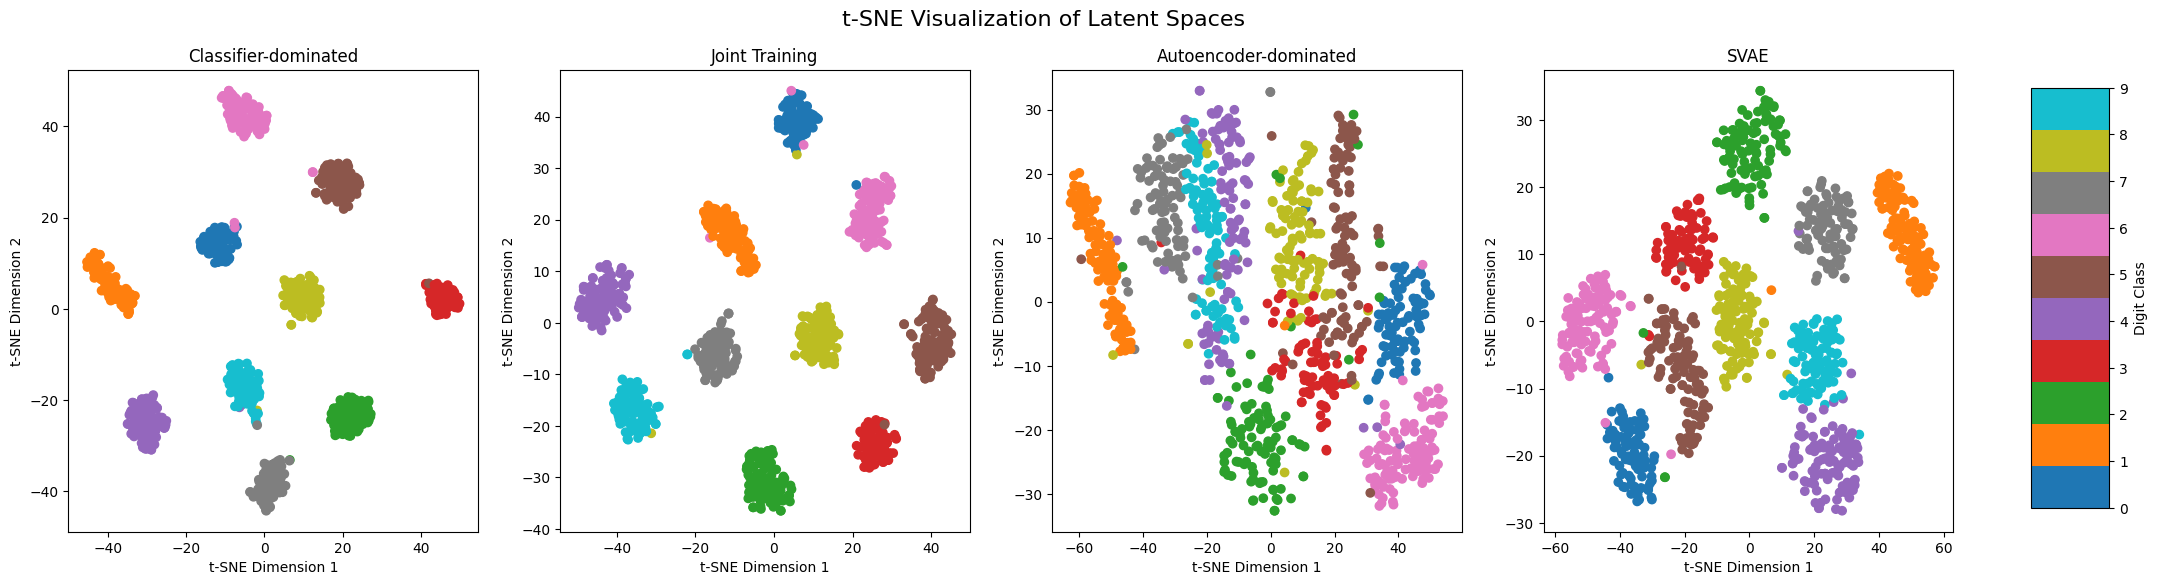

In [69]:
# Get sample of training images
random_indices = torch.randint(0, len(testset), (1000,))
images = torch.stack([testset[i][0] for i in random_indices])
labels = torch.tensor([testset[i][1] for i in random_indices])
images = images.to(device)

# Get latent representations from each model
latent_spaces = []
with torch.no_grad():
    for classifier, _ in models:
        classifier.eval()
        latent_reps, _ = classifier(images)
        latent_spaces.append(latent_reps.cpu().numpy())

# Create visualization
fig, axes = plt.subplots(1, 4, figsize=(26, 6))
fig.suptitle('t-SNE Visualization of Latent Spaces', fontsize=16)
model_names = ['Classifier-dominated', 'Joint Training', 'Autoencoder-dominated', 'SVAE']

# Plot each latent space
for i, (latent_reps, name) in enumerate(zip(latent_spaces, model_names)):
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_reps)
    scatter = axes[i].scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10')
    axes[i].set_title(name)
    axes[i].set_xlabel('t-SNE Dimension 1')
    axes[i].set_ylabel('t-SNE Dimension 2')

# Add colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
fig.colorbar(scatter, cax=cbar_ax, label='Digit Class')

plt.show()

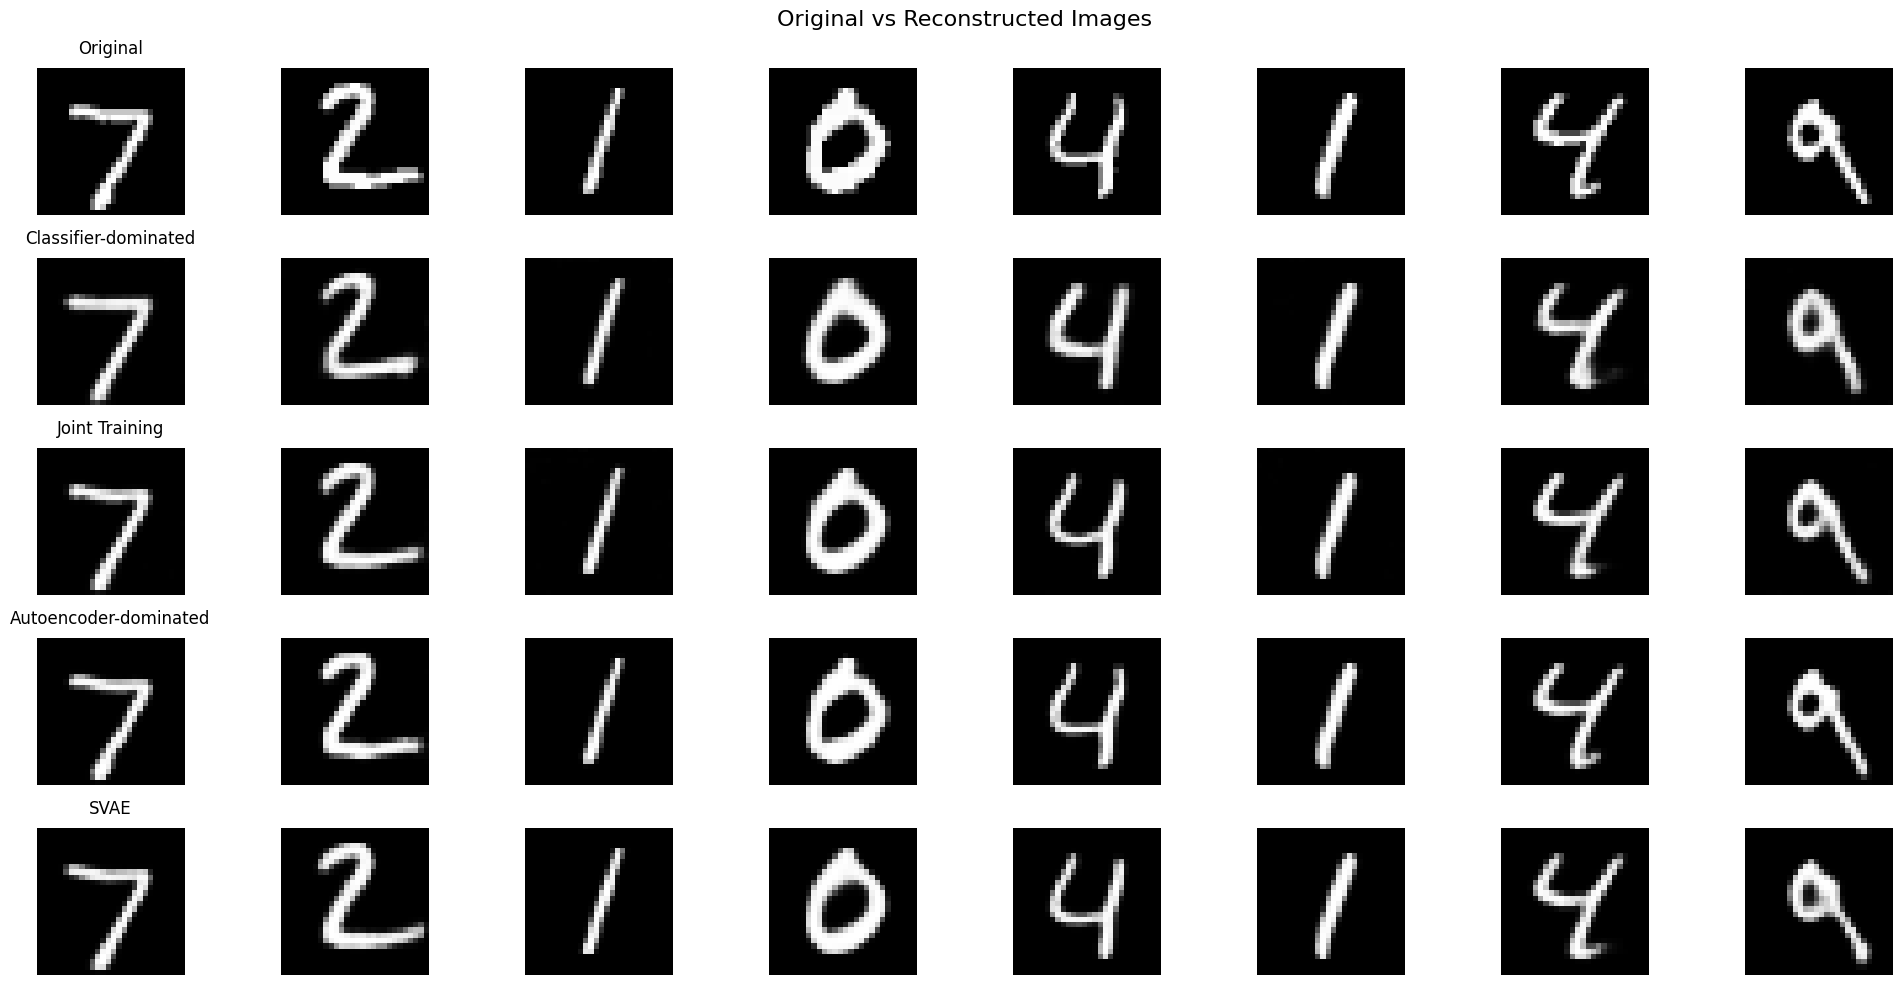

In [70]:
# Get test images
test_images, test_labels = next(iter(testloader))
test_images = test_images.to(device)

# Get reconstructions from each model
reconstructions = []
with torch.no_grad():
    for classifier, decoder in models:
        z, _ = classifier(test_images)
        recon = decoder(z)
        reconstructions.append(recon.cpu().numpy())

# Convert test images to numpy for plotting
test_images = test_images.cpu().numpy()

# Plot original and reconstructed images
fig, axes = plt.subplots(5, 8, figsize=(20, 10))
fig.suptitle('Original vs Reconstructed Images', fontsize=16)

# Plot original images
for i in range(8):
    axes[0,i].imshow(test_images[i,0], cmap='gray')
    axes[0,i].axis('off')
    if i == 0:
        axes[0,i].set_title('Original', pad=10)

# Plot reconstructions for each model
model_names = ['Classifier-dominated', 'Joint Training', 'Autoencoder-dominated', 'SVAE']
for row, (recon, name) in enumerate(zip(reconstructions, model_names), start=1):
    for i in range(8):
        axes[row,i].imshow(recon[i,0], cmap='gray')
        axes[row,i].axis('off')
        if i == 0:
            axes[row,i].set_title(name, pad=10)

plt.tight_layout()
plt.show()
